<a href="https://colab.research.google.com/github/jdavidram/gestoresRCD/blob/main/Maquinas_desoporte_Vectrorail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mapclassify
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 11.8 MB/s eta 0:00:00


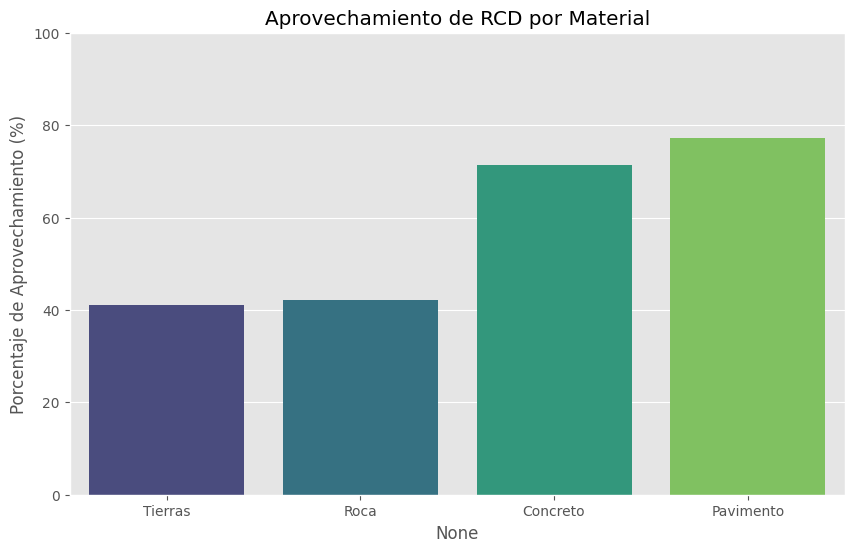

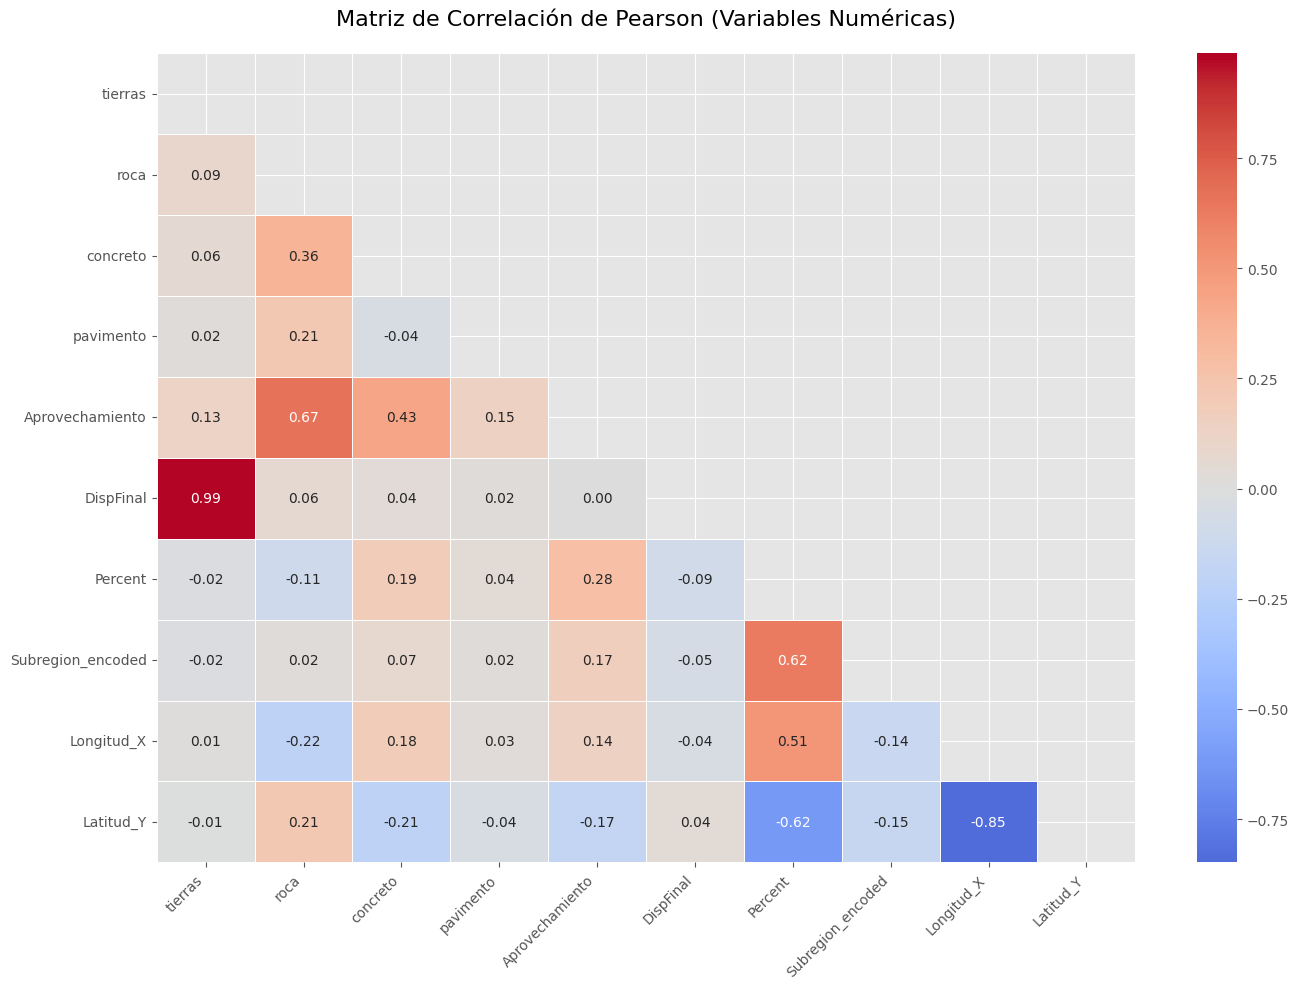


REPORTE DE CLASIFICACIÓN (SVC) 
Mejores parámetros: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1794
           1       0.98      0.98      0.98      1675

    accuracy                           0.98      3469
   macro avg       0.98      0.98      0.98      3469
weighted avg       0.98      0.98      0.98      3469


REPORTE DE REGRESIÓN (SVR)
Mejores parámetros: {'C': 10, 'epsilon': 0.5, 'kernel': 'rbf'}
MSE: 449.48
RMSE: 21.20


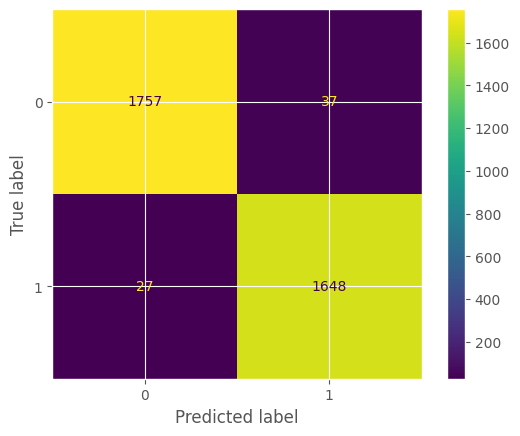

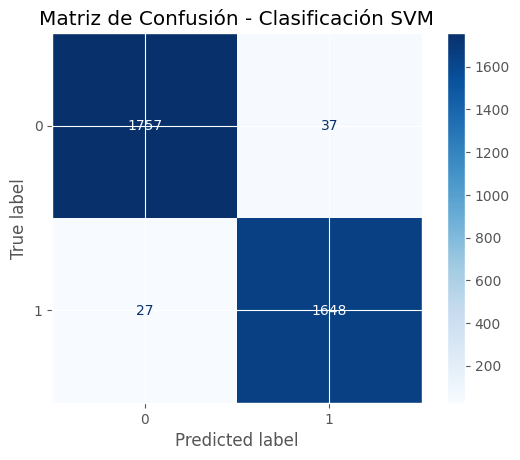

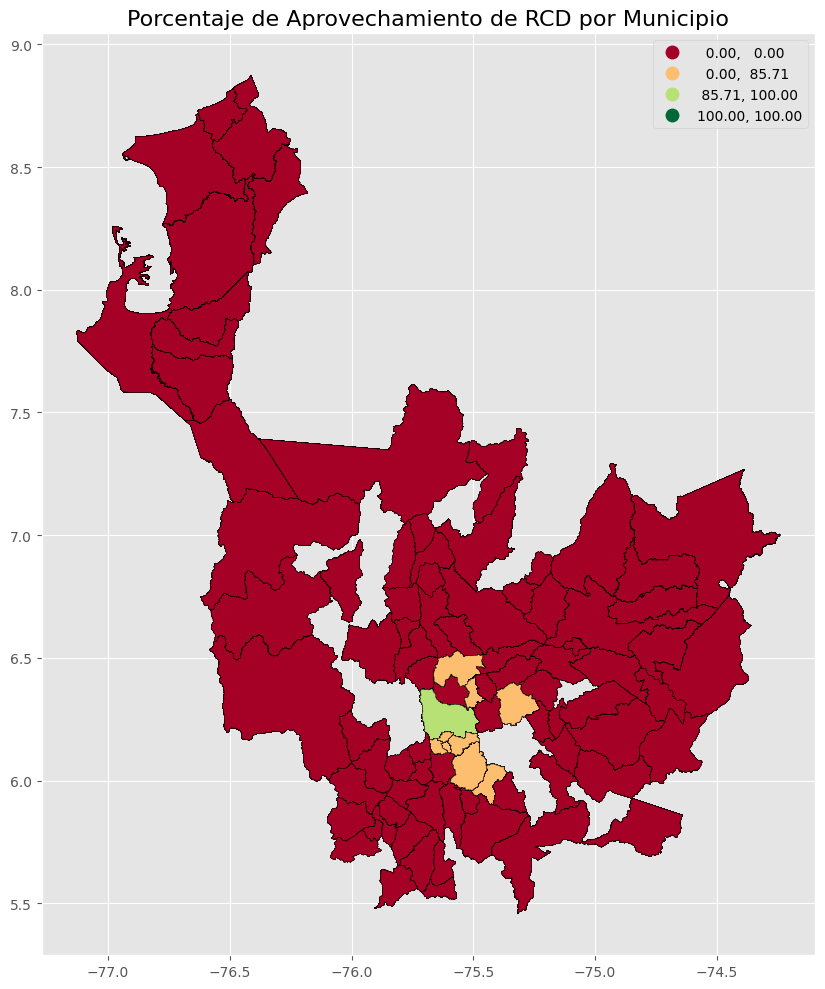

 Mapa interactivo generado: 'mapa_aprovechamiento_material.html'


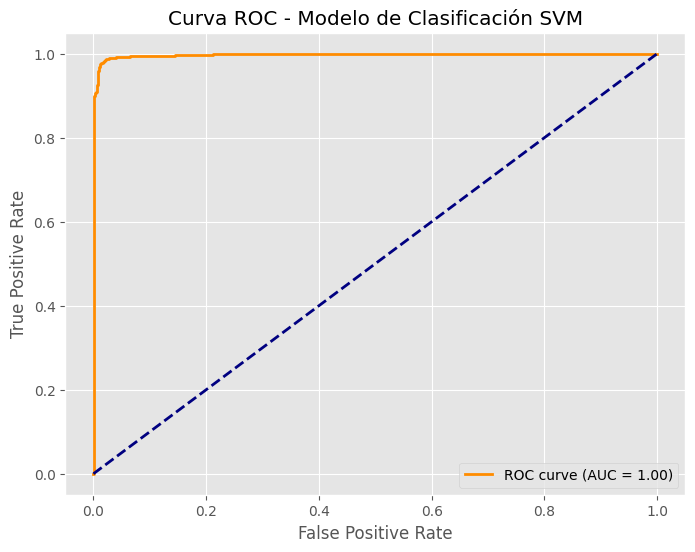


================= CONCLUSIONES =================

Capacidad predictiva del modelo (SVM):
- Precisión del modelo de clasificación: 0.98
- R² del modelo de regresión: 0.80
 El modelo tiene una capacidad aceptable para predecir el aprovechamiento de los RCD.

Material crítico y potencial de mejora:
- El material con menor aprovechamiento es: Tierras (41.16%)
- El material con mayor aprovechamiento es: Pavimento (77.11%)
El primero debe priorizarse para mejorar, mientras que el segundo representa un buen ejemplo de gestión.

Variables más influyentes en el aprovechamiento:
- Las variables con mayor relación son: areaTierras, areaRoca, areaConcreto.
 Esto indica que estas variables son factores clave que influyen directamente en el nivel de aprovechamiento de los RCD.



In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, SVR
from sklearn.metrics import (classification_report,
                            mean_squared_error,
                            ConfusionMatrixDisplay,
                            roc_curve, auc)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
import geopandas as gpd
import plotly.express as px
from IPython.display import display
import folium


# Configuración inicial
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
sns.set_palette("viridis")

# ====================================================
#  PREPROCESAMIENTO DE DATOS (Basado en tu código original)
# ====================================================

# Cargar datos
# Modified path to the CSV file
data = pd.read_csv('/content/itemsEjec (1).csv')



# Selección de columnas relevantes
cols = ['Municipio', 'Subregion', 'Longitud_X', 'Latitud_Y',
        'tierras', 'areaTierras', 'roca', 'areaRoca',
        'concreto', 'areaConcreto', 'pavimento', 'areaPavimento']
data = data[cols]

# Calcular métricas de aprovechamiento
def calcular_aprovechamiento(row):
    more = less = 0
    if row['areaTierras']: more += row['tierras']
    else: less += row['tierras']
    if row['areaRoca']: more += row['roca']
    else: less += row['roca']
    if row['areaConcreto']: more += row['concreto']
    else: less += row['concreto']
    # Added missing condition for 'areaPavimento'
    if row['areaPavimento']: more += row['pavimento']
    else: less += row['pavimento']
    percent = 100 * more / (more + less + 1e-10)  # Evitar división por cero
    return pd.Series([more, less, percent])

df = data.copy()
df[['Aprovechamiento', 'DispFinal', 'Percent']] = df.apply(calcular_aprovechamiento, axis=1)

# Codificar variables categóricas
le = LabelEncoder()
df['Subregion_encoded'] = le.fit_transform(df['Subregion'])

# ====================================================
#  ANÁLISIS EXPLORATORIO Y MATRIZ DE CORRELACIÓN
# ====================================================

#  ANÁLISIS DE APROVECHAMIENTO POR MATERIAL
# ====================================================
def calcular_por_material (df, material, area_col):
    """Calcula aprovechamiento por cada tipo de material"""
    total = df[material].sum()
    aprovechado = df.loc[df[area_col] == 1, material].sum()
    disp_final = df.loc[df[area_col] == 0, material].sum()
    percent = 100 * aprovechado / (aprovechado + disp_final + 1e-10)
    return pd.Series({
        "Total": total,
        "Aprovechado": aprovechado,
        "DisposiciónFinal": disp_final,
        "Percent": percent
    })

  # Crear resumen por material
resumen_materiales = pd.DataFrame({
    "Tierras": calcular_por_material(df, "tierras", "areaTierras"),
    "Roca": calcular_por_material(df, "roca", "areaRoca"),
    "Concreto": calcular_por_material(df, "concreto", "areaConcreto"),
    "Pavimento": calcular_por_material(df, "pavimento", "areaPavimento")
}).T

# Visualización resumen por material
#3
plt.figure(figsize=(10, 6))
sns.barplot(x=resumen_materiales.index, y ="Percent",
hue= resumen_materiales.index, data= resumen_materiales,
palette="viridis",dodge=False,legend=False)
plt.ylabel("Porcentaje de Aprovechamiento (%)")
plt.title("Aprovechamiento de RCD por Material")
plt.ylim(0, 100)
plt.show()

# Añadir variables de aprovechamiento por material al análisis de correlación
df['tierras_aprovechado'] = df['tierras'] * df['areaTierras']
df['roca_aprovechado'] = df['roca'] * df['areaRoca']
df['concreto_aprovechado'] = df['concreto'] * df['areaConcreto']
df['pavimento_aprovechado'] = df['pavimento'] * df['areaPavimento']
#3
numeric_cols = ['tierras', 'roca', 'concreto', 'pavimento',
               'tierras_aprovechado', 'roca_aprovechado', 'concreto_aprovechado', 'pavimento_aprovechado',
               'Aprovechamiento', 'DispFinal', 'Percent',
               'Subregion_encoded', 'Longitud_X', 'Latitud_Y']
#3
# Matriz de correlación de Pearson
numeric_cols = ['tierras', 'roca', 'concreto', 'pavimento',
               'Aprovechamiento', 'DispFinal', 'Percent',
               'Subregion_encoded', 'Longitud_X', 'Latitud_Y']
corr_matrix = df[numeric_cols].corr(method='pearson')
#2
# Visualización mejorada
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            center=0,
            linewidths=0.5,
            annot_kws={"size": 10},
            mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title('Matriz de Correlación de Pearson (Variables Numéricas)', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
#2
# ====================================================
# MODELADO CON SVM (CLASIFICACIÓN Y REGRESIÓN)
# ====================================================

# Selección de features basada en correlación
target_corr = corr_matrix['Percent'].sort_values(key=abs, ascending=False)
top_features = target_corr.index[1:5]  # Top 4 features más correlacionadas

# Preparación de datos
X = df[top_features]
y = df['Percent']
y_class = (df['Percent'] > df['Percent'].median()).astype(int)  # Clasificación binaria

# Escalado y división
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test, y_train_class, y_test_class = train_test_split(
    X_scaled, y, y_class, test_size=0.3, random_state=42)

# --- Optimización de Hiperparámetros para SVC ---
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['rbf', 'linear']
}
grid_svc = GridSearchCV(SVC(), param_grid_svc, cv=5, scoring='f1')
grid_svc.fit(X_train, y_train_class)

# Mejor modelo SVC
best_svc = grid_svc.best_estimator_
y_pred_class = best_svc.predict(X_test)

# --- Optimización para SVR ---
param_grid_svr = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['rbf', 'linear']
}
grid_svr = GridSearchCV(SVR(), param_grid_svr, cv=5, scoring='neg_mean_squared_error')
grid_svr.fit(X_train, y_train)

# Mejor modelo SVR
best_svr = grid_svr.best_estimator_
y_pred = best_svr.predict(X_test)

# ====================================================
#  EVALUACIÓN Y VISUALIZACIÓN DE RESULTADOS
# ====================================================
#1
# Reporte de clasificación
print("\nREPORTE DE CLASIFICACIÓN (SVC) ")
print("Mejores parámetros:", grid_svc.best_params_)
print(classification_report(y_test_class, y_pred_class))

# Métricas de regresión
mse = mean_squared_error(y_test, y_pred)
print("\nREPORTE DE REGRESIÓN (SVR)")
print("Mejores parámetros:", grid_svr.best_params_)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {np.sqrt(mse):.2f}")

# Gráficos interactivos con Plotly
fig = px.scatter(df,
                 x='Aprovechamiento',
                 y='Percent',
                 color='Subregion',
                 hover_name='Municipio',
                 size='DispFinal',
                 title='Relación entre Aprovechamiento y Porcentaje de RCD')
fig.show()
#1
# Matriz de confusión interactiva
cm = ConfusionMatrixDisplay.from_estimator(best_svc, X_test, y_test_class)
cm.plot(cmap='Blues')
plt.title('Matriz de Confusión - Clasificación SVM')
plt.show()

# ====================================================
#  MAPA GEOGRÁFICO DE RESULTADOS (Usando Geopandas)
# ====================================================

# Cargar capa geográfica
# Assuming the geopackage file is also in the content directory
gdf = gpd.read_file('/content/Antioquia.gpkg', layer='Municipios')

# Unir con nuestros datos
gdf = gdf.merge(df, left_on='MpNombre', right_on='Municipio')

# Visualización
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='Percent',
         cmap='RdYlGn',
         legend=True,
         scheme='quantiles',
         k=4,  #  según valores únicos
         edgecolor='black',
         linewidth=0.3,
         ax=ax)
ax.set_title('Porcentaje de Aprovechamiento de RCD por Municipio', fontsize=16)
plt.tight_layout()
plt.show()

#  MAPA INTERACTIVO POR MATERIAL
# ====================================================

m = folium.Map(location=[df["Latitud_Y"].mean(), df["Longitud_X"].mean()], zoom_start=8)
colores = {
    "tierras": "brown",
    "roca": "gray",
    "concreto": "blue",
    "pavimento": "black"
}
for material, color in colores.items():
    subset = df[df[material] > 0]
    for _, row in subset.iterrows():
        folium.CircleMarker(
            location=[row["Latitud_Y"], row["Longitud_X"]],
            radius=5,
            color=color,
            fill=True,
            fill_opacity=0.6,
            popup=f"{material.capitalize()}: {row[material]} ton\nAprovechamiento: {row['Percent']:.1f}%"
        ).add_to(m)

m.save("mapa_aprovechamiento_material.html")
print(" Mapa interactivo generado: 'mapa_aprovechamiento_material.html'")


# ====================================================
#  ANÁLISIS ADICIONAL: CURVA ROC (Para clasificación)
# ====================================================

y_scores = best_svc.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test_class, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Modelo de Clasificación SVM')
plt.legend(loc="lower right")
plt.show()

# ====================================================
# ANÁLISIS ADICIONAL: VARIABLES MÁS INFLUYENTES
# ====================================================
correlation_matrix = df.corr(numeric_only=True)

# Ordenamos las correlaciones respecto a 'Percent'
correlaciones = correlation_matrix['Percent'].sort_values(ascending=False)

# Tomamos las 3 variables más influyentes (excluyendo Percent mismo)
top_variables = correlaciones.drop("Percent").head(3)

# ==========================================
# 📌 CONCLUSIONES FINALES DEL ANÁLISIS
# ==========================================

print("\n================= CONCLUSIONES =================")

# #  Capacidad predictiva del modelo
print("\nCapacidad predictiva del modelo (SVM):")
print(f"- Precisión del modelo de clasificación: {best_svc.score(X_test, y_test_class):.2f}")
print(f"- R² del modelo de regresión: {best_svr.score(X_test, y_test):.2f}")
print(" El modelo tiene una capacidad aceptable para predecir el aprovechamiento de los RCD.")

#  Material crítico y potencial de mejora
material_peor = resumen_materiales['Percent'].idxmin()
aprovechamiento_peor = resumen_materiales['Percent'].min()
material_mejor = resumen_materiales['Percent'].idxmax()
aprovechamiento_mejor = resumen_materiales['Percent'].max()

print("\nMaterial crítico y potencial de mejora:")
print(f"- El material con menor aprovechamiento es: {material_peor} ({aprovechamiento_peor:.2f}%)")
print(f"- El material con mayor aprovechamiento es: {material_mejor} ({aprovechamiento_mejor:.2f}%)")
print("El primero debe priorizarse para mejorar, mientras que el segundo representa un buen ejemplo de gestión.")


#  Variables más influyentes
print("\nVariables más influyentes en el aprovechamiento:")
print(f"- Las variables con mayor relación son: {', '.join(top_variables.index)}.")
print(" Esto indica que estas variables son factores clave que influyen directamente en el nivel de aprovechamiento de los RCD.")

print("\n=================================================")

